Load HCP data and connectivity analysis.

# Tutorial PCA

# Data load

In [2]:
# #%pip install google.colab
# #from google.colab import drive
# import os
# import requests
# import tarfile

# # Montar Google Drive
# #drive.mount('/content/drive')

# # Definir directorios y archivos
# #drive_dir = "/content/drive/My Drive/HCP_data"
# dir = r"C:\Users\cwako\OneDrive\NMA"
# os.makedirs(dir, exist_ok=True)
# fnames = ["hcp_rest.tgz",
#           "hcp_task.tgz",
#           "hcp_covariates.tgz",
#           "atlas.npz"]
# urls = ["https://osf.io/bqp7m/download",
#         "https://osf.io/s4h8j/download",
#         "https://osf.io/x5p4g/download",
#         "https://osf.io/j5kuc/download"]
# # Función para descargar archivos
# def download_file(url, fname):
#     try:
#         r = requests.get(url)
#         r.raise_for_status()  # Check for HTTP errors
#     except requests.ConnectionError:
#         print("!!! Failed to download data: Connection Error !!!")
#     except requests.HTTPError as err:
#         print(f"!!! Failed to download data: HTTP Error {err} !!!")
#     else:
#         print(f"Downloading {fname}...")
#         with open(fname, "wb") as fid:
#             fid.write(r.content)
#         print(f"Download {fname} completed!")

# # Descargar los archivos si no existen en Google Drive
# for fname, url in zip(fnames, urls):
#     drive_path = os.path.join(dir, fname)
#     if not os.path.isfile(drive_path):
#         download_file(url, drive_path)
#     else:
#         print(f"{fname} already exists in Google Drive.")

# # Si necesitas extraer los archivos
# def extract_file(filepath, extract_to):
#     if tarfile.is_tarfile(filepath):
#         with tarfile.open(filepath) as tar:
#             tar.extractall(path=extract_to)
#         print(f"Extracted {os.path.basename(filepath)} to {extract_to}")
#     else:
#         print(f"{os.path.basename(filepath)} is not a valid tar file.")

# for fname in fnames:
#     drive_path = os.path.join(dir, fname)
#     extract_file(drive_path, dir)


In [3]:
from google.colab import drive
import os
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Define directory
drive_dir = "/content/drive/My Drive/HCP_data"
extracted_dirs = ["hcp_rest", "hcp_task", "hcp"]

# Define paths to extracted files
rest_path = os.path.join(drive_dir, extracted_dirs[0])
task_path = os.path.join(drive_dir, extracted_dirs[1])
covariates_path = os.path.join(drive_dir, extracted_dirs[2], "behavior")
atlas_path = os.path.join(drive_dir, "atlas.npz")

# Load the atlas file
with np.load(atlas_path) as dobj:
    atlas = dict(**dobj)

# Your code to work with the extracted data
# For example, list files in the directories
rest_files = os.listdir(rest_path)
task_files = os.listdir(task_path)
covariates_files = os.listdir(covariates_path)

print("Resting-state fMRI files:", rest_files)
print("Task-based fMRI files:", task_files)
print("Covariates files:", covariates_files)


Mounted at /content/drive
Resting-state fMRI files: ['regions.npy', 'subjects']
Task-based fMRI files: ['regions.npy', 'subjects']
Covariates files: ['gambling.csv', 'language.csv', 'emotion.csv', 'wm.csv', 'relational.csv', 'social.csv']


In [4]:
%pip install numpy
%pip install pyplot
%pip install nilearn --quiet
%pip install matplotlib

ERROR: Could not find a version that satisfies the requirement pyplot (from versions: none)
ERROR: No matching distribution found for pyplot
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 33.2 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import plotting, datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
import seaborn as sns


In [6]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "/content/drive/My Drive/HCP_data"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# MATRIX LOADING

In [7]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools,
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

In [8]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])


    # Concatenate the selected data along the time points axis
    concatenated_data = np.concatenate(selected_data, axis=-1)

  return concatenated_data

  # # Take the average in each parcel
  # avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  # return avg_data

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [9]:
timeseries_task = []
for subject in subjects:
  ts_concat_task = load_timeseries(subject, name="language", dir=os.path.join(HCP_DIR, "hcp_task"))
  timeseries_task.append(ts_concat_task)


In [10]:
task = "language"
conditions = ["response_story"]  # Run a substraction analysis between two conditions

contrast = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
  #because we used two runs we concatenate them. the functions defined above, fon't concat by default.
  evs = np.concatenate(evs, axis=0)
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0])

group_contrast = np.mean(contrast, axis=0)

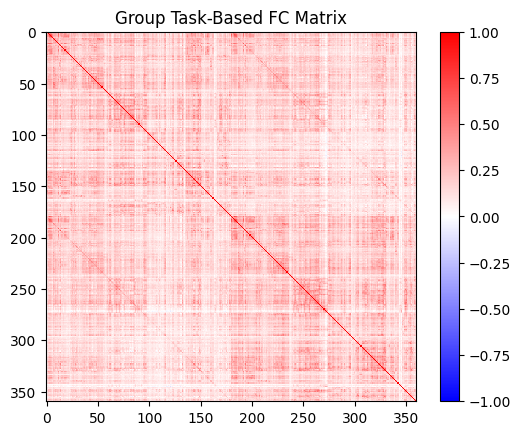

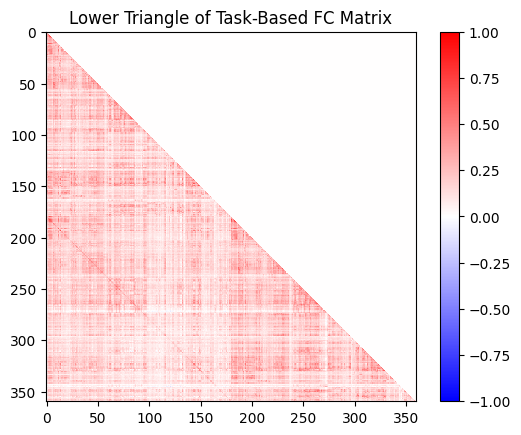

In [11]:
# Construct the task-based FC matrix for STORY task
task_fc_matrix = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
#here used contrast from above cell, which is the frames related to the story
for sub, ts in enumerate(contrast):
    task_fc_matrix[sub] = np.corrcoef(ts)

group_task_fc = task_fc_matrix.mean(axis=0)

plt.figure()
plt.imshow(group_task_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.title('Group Task-Based FC Matrix')
plt.show()

# Extract the lower triangle for analysis
lower_triangle_task = np.tril(task_fc_matrix, k=-1)
group_task_fc_lower = lower_triangle_task.mean(axis=0)

plt.figure()
plt.imshow(group_task_fc_lower, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.title('Lower Triangle of Task-Based FC Matrix')
plt.show()

#Construct functional connectivity matrix (FC_task) for task_based analysis


## Run a simple subtraction analysis

In [12]:
# task = "language"
# conditions = ["response_story"]  # Run a one sample analysis for story

# contrast = []
# for subject in subjects:

#   # Get the average signal in each region for each condition
#   evs = [load_evs(subject, task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
#   avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

#   # Store the region-wise difference
#   contrast.append(avgs[0])

# group_contrast_task = np.mean(contrast, axis=0)

# Average difficulty vector

<ipython-input-13-12e322ec5b88>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_dif_df['Label'] = (avg_dif_df['AVG_DIFFICULTY_LEVEL'] > threshold).astype(int)


     Subject  AVG_DIFFICULTY_LEVEL  Label
0          0              8.892857      0
1          1             10.089286      0
2          2             10.053571      0
3          3              8.767857      0
4          4              9.357143      0
..       ...                   ...    ...
334      334             12.446429      1
335      335              8.750000      0
336      336              9.464286      0
337      337             11.178571      1
338      338              9.375000      0

[339 rows x 3 columns]


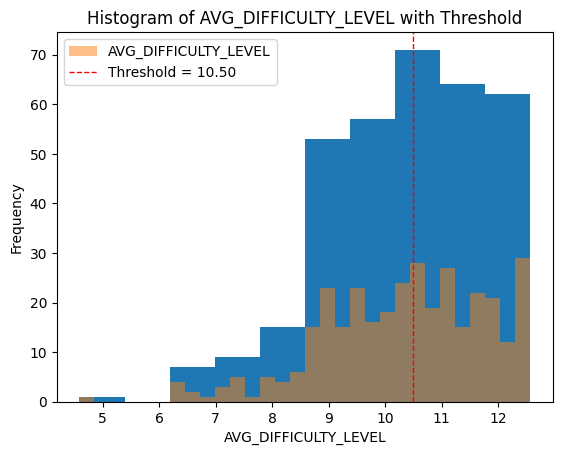

[0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1
 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1
 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1
 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0
 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0
 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0
 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1
 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0
 0 1 0 0 1 0]


In [13]:
language_df = pd.read_csv(os.path.join(covariates_path, "language.csv"))
filtered_df = language_df[language_df['ConditionName'] == 'STORY']
run_mean = filtered_df.groupby('Subject')[['ACC', 'AVG_DIFFICULTY_LEVEL', 'MEDIAN_RT']].mean().reset_index()

avg_dif_df = run_mean[['Subject', 'AVG_DIFFICULTY_LEVEL']]

avg_dif_df.head()

#plt.hist(run_mean['ACC'])
plt.hist(run_mean['AVG_DIFFICULTY_LEVEL'])

# Define the threshold
threshold = 10.5

# Function to assign the labels, if value in the column is above the threshold Ture, as tyoe converts boolean into binary numbers (0, 1)
avg_dif_df['Label'] = (avg_dif_df['AVG_DIFFICULTY_LEVEL'] > threshold).astype(int)
print(avg_dif_df)

# Histogram of average difficulty
plt.hist(avg_dif_df['AVG_DIFFICULTY_LEVEL'], bins=30, alpha=0.5, label='AVG_DIFFICULTY_LEVEL')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label=f'Threshold = {threshold:.2f}')
plt.xlabel('AVG_DIFFICULTY_LEVEL')
plt.ylabel('Frequency')
plt.title('Histogram of AVG_DIFFICULTY_LEVEL with Threshold')
plt.legend()
plt.show()

# Vector de etiquetas
labels_vector = avg_dif_df['Label'].values
print(labels_vector)

In [14]:
print(max(avg_dif_df['AVG_DIFFICULTY_LEVEL']))
print(min(avg_dif_df['AVG_DIFFICULTY_LEVEL']))

12.57142857145
4.589285714285


# Accuracy vectors

     Subject    ACC  Label
0          0  0.875      1
1          1  1.000      1
2          2  1.000      1
3          3  0.750      0
4          4  0.875      1
..       ...    ...    ...
334      334  1.000      1
335      335  0.875      1
336      336  0.875      1
337      337  1.000      1
338      338  1.000      1

[339 rows x 3 columns]


<ipython-input-15-852c2c7684d4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_m['Label'] = (accuracy_m['ACC'] > threshold).astype(int)


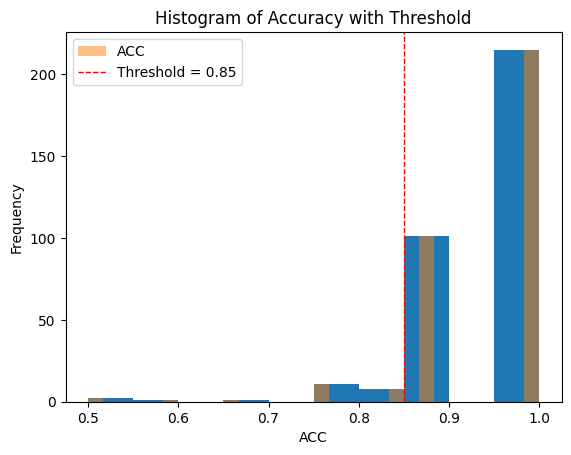

[1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]


In [15]:
filtered_df = language_df[language_df['ConditionName'] == 'STORY']
run_mean = filtered_df.groupby('Subject')[['ACC', 'AVG_DIFFICULTY_LEVEL', 'MEDIAN_RT']].mean().reset_index()

accuracy_m = run_mean[['Subject', 'ACC']]

accuracy_m.head()

#plt.hist(run_mean['ACC'])
plt.hist(run_mean['ACC'])

# Define the threshold
threshold = 0.85

# Function to assign the labels, if value in the column is above the threshold Ture, as tyoe converts boolean into binary numbers (0, 1)
accuracy_m['Label'] = (accuracy_m['ACC'] > threshold).astype(int)
print(accuracy_m)

# Histogram of average difficulty
plt.hist(accuracy_m['ACC'], bins=30, alpha=0.5, label='ACC')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label=f'Threshold = {threshold:.2f}')
plt.xlabel('ACC')
plt.ylabel('Frequency')
plt.title('Histogram of Accuracy with Threshold')
plt.legend()
plt.show()

# Vector de etiquetas
labels_vector_acc = accuracy_m['Label'].values
print(labels_vector_acc)

# PCA

In [16]:
# Assuming you have already calculated the group connectivity matrix
# group_fc has dimensions(N_PARCELS, N_PARCELS)

# Flatten the functional connectivity matrix for each subject
lower_triangle_indices = np.tril_indices(N_PARCELS, k=-1)


flat_fc_task = [fc[lower_triangle_indices] for fc in lower_triangle_task]

# Convert to a numpy array
flat_fc_task = np.array(flat_fc_task)

print(flat_fc_task.shape)  # Should be (N_SUBJECTS, N_PARCELS*(N_PARCELS-1)/2)


(339, 64620)


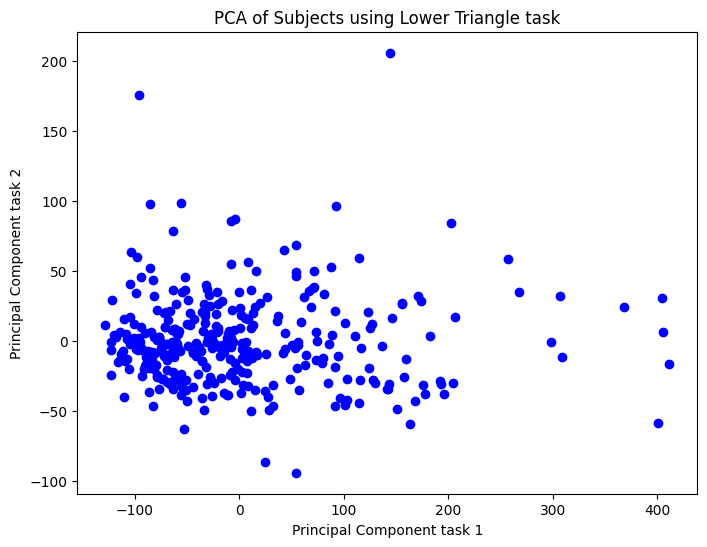

[[ 4.30872847e-03  4.00681303e-03  4.31905650e-03 ...  3.07217408e-03
   3.65733874e-03  3.34963382e-03]
 [-5.12965509e-03 -8.16134597e-03 -2.07220433e-03 ... -2.47116139e-04
   4.39001856e-04  3.92395535e-03]
 [ 4.19847646e-03  3.28427314e-03  2.97272287e-03 ...  3.93637789e-04
  -1.47340566e-03  5.46222687e-03]
 ...
 [-5.27502386e-03 -3.42769542e-03 -4.14783460e-03 ... -1.05311606e-03
   5.28260612e-04 -1.47302788e-04]
 [ 4.47980888e-03  1.18399989e-03  4.04915251e-03 ... -6.21743592e-03
   1.52862083e-03 -3.32254821e-05]
 [-2.83360500e-03  4.94940710e-04 -5.23418537e-03 ...  1.48523081e-03
   1.42081665e-03  1.29410007e-03]]


In [17]:
# Step 2: Standardize the data
scaler_task = StandardScaler()
standardized_data_task = scaler_task.fit_transform(flat_fc_task)

# Step 3: Perform PCA
pca_task = PCA(50)  # You can adjust the number of components
principal_components_task = pca_task.fit_transform(standardized_data_task)

# Step 4: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(principal_components_task[:, 0], principal_components_task[:, 1], c='blue')
plt.xlabel('Principal Component task 1')
plt.ylabel('Principal Component task 2')
plt.title('PCA of Subjects using Lower Triangle task')
plt.show()

# Explained variance
explained_variance_task = pca_task.explained_variance_ratio_
weights_task = pca_task.components_
print(weights_task)


In [18]:
print(principal_components_task.shape)

(339, 50)


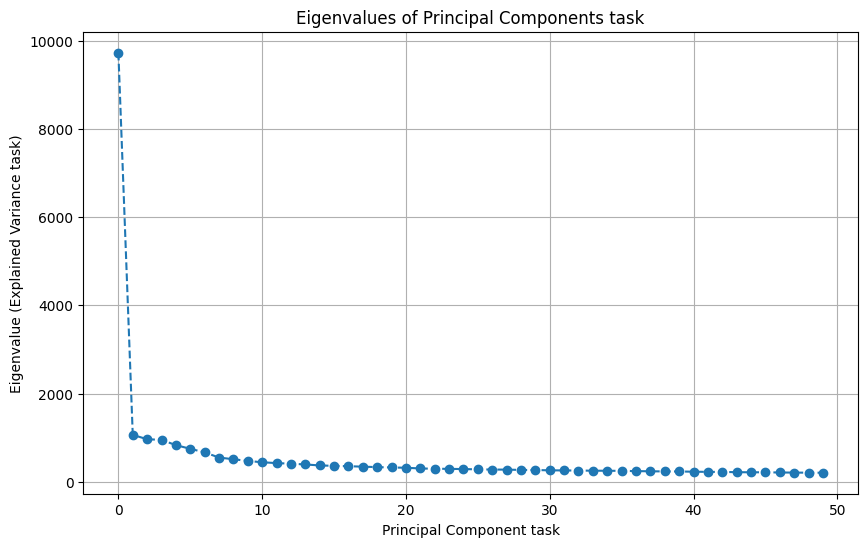

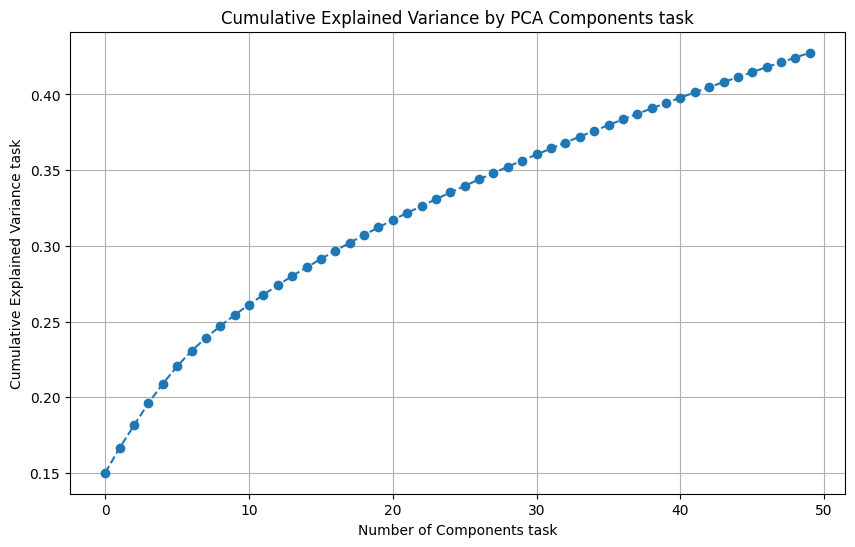

In [19]:
# # # Explained variance
explained_variance_task = pca_task.explained_variance_
explained_variance_ratio_task = pca_task.explained_variance_ratio_

# # # Plot eigenvalues (explained variance)
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_task, marker='o', linestyle='--')
plt.xlabel('Principal Component task')
plt.ylabel('Eigenvalue (Explained Variance task)')
plt.title('Eigenvalues of Principal Components task')
plt.grid(True)
plt.show()

# # # Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio_task), marker='o', linestyle='--')
plt.xlabel('Number of Components task')
plt.ylabel('Cumulative Explained Variance task')
plt.title('Cumulative Explained Variance by PCA Components task')
plt.grid(True)
plt.show()

In [20]:
explained_variance_task = pca_task.explained_variance_ratio_
weights_task = pca_task.components_
print(weights_task.shape)
weights_transposed_task = weights_task.T

# Create a DataFrame
weights_df_task = pd.DataFrame(weights_transposed_task, columns=[f"PC{i+1}" for i in range(weights_task.shape[0])], index=range(1, weights_task.shape[1] + 1))

print(weights_df_task)
print(max(weights_df_task))

(50, 64620)
            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
1      0.004309 -0.005130  0.004198  0.001055  0.006148 -0.003977  0.000956   
2      0.004007 -0.008161  0.003284  0.000150 -0.000377 -0.007331 -0.004596   
3      0.004319 -0.002072  0.002973  0.001133  0.004869 -0.003740 -0.001770   
4      0.003698 -0.007909  0.001105  0.001584 -0.000091 -0.005146 -0.001376   
5      0.004611 -0.004940  0.004232  0.000120  0.007071 -0.004378  0.001221   
...         ...       ...       ...       ...       ...       ...       ...   
64616  0.004635 -0.002551  0.001176 -0.001580 -0.008174  0.000332  0.001522   
64617  0.003734 -0.001293 -0.002948  0.000180 -0.006603  0.004414 -0.000121   
64618  0.003072 -0.000247  0.000394 -0.000126 -0.006819 -0.002634 -0.000029   
64619  0.003657  0.000439 -0.001473  0.003125 -0.004114  0.001608 -0.002165   
64620  0.003350  0.003924  0.005462 -0.001627 -0.004274  0.000527  0.004525   

            PC8       PC9      PC10  ..

In [21]:
explained_variance_ratio_task = pca_task.explained_variance_ratio_

# Print the explained variance ratio for each component
for i, ratio in enumerate(explained_variance_ratio_task):
    print(f"Component {i+1}: Explained Variance Ratio = {ratio:.8f}")

Component 1: Explained Variance Ratio = 0.15010074
Component 2: Explained Variance Ratio = 0.01640390
Component 3: Explained Variance Ratio = 0.01488261
Component 4: Explained Variance Ratio = 0.01465114
Component 5: Explained Variance Ratio = 0.01281806
Component 6: Explained Variance Ratio = 0.01152604
Component 7: Explained Variance Ratio = 0.01028950
Component 8: Explained Variance Ratio = 0.00846799
Component 9: Explained Variance Ratio = 0.00788493
Component 10: Explained Variance Ratio = 0.00729147
Component 11: Explained Variance Ratio = 0.00681971
Component 12: Explained Variance Ratio = 0.00652987
Component 13: Explained Variance Ratio = 0.00632496
Component 14: Explained Variance Ratio = 0.00605423
Component 15: Explained Variance Ratio = 0.00571290
Component 16: Explained Variance Ratio = 0.00556781
Component 17: Explained Variance Ratio = 0.00544385
Component 18: Explained Variance Ratio = 0.00528303
Component 19: Explained Variance Ratio = 0.00512497
Component 20: Explain

we can try to do a linear regression to predict the avg_difficult instead of a clasiffier and we won't need the labels

# The model starts here

In [22]:
avg_dif_df

,Subject,AVG_DIFFICULTY_LEVEL,Label
0,0,8.892857,0
1,1,10.089286,0
2,2,10.053571,0
3,3,8.767857,0
4,4,9.357143,0
...,...,...,...
334,334,12.446429,1
335,335,8.750000,0
336,336,9.464286,0
337,337,11.178571,1


In [23]:
# principal_components_task

# try other models
random forest, decision making trees, svm,
feature selection (other than pca)
knearest neighbour


# Model on Average difficulty

In [24]:
# Assuming principal_components is your feature data and y is your target variable
X = principal_components_task
y = labels_vector  # Replace with your actual target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

# Initialize the classifier
classifier = LogisticRegression(random_state=42, solver = "liblinear")

# Train the classifier
classifier.fit(X_train, y_train)



# Make predictions
y_pred = classifier.predict(X_test)
y_pred_prob_pca_lr = classifier.predict_proba(X_test)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(matrix)



Accuracy: 0.6176470588235294
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.57      0.57        30
           1       0.66      0.66      0.66        38

    accuracy                           0.62        68
   macro avg       0.61      0.61      0.61        68
weighted avg       0.62      0.62      0.62        68

Confusion Matrix:
[[17 13]
 [13 25]]


In [25]:
atlas.keys()

dict_keys(['labels_R', 'labels_L', 'coords'])

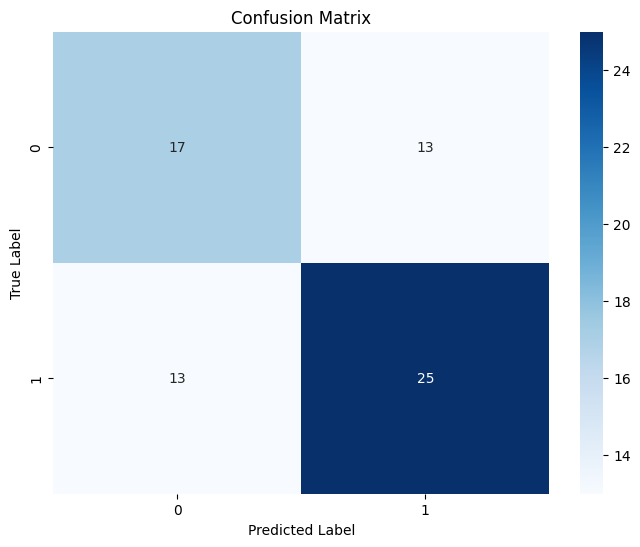

In [26]:
# Compute the confusion matrix
matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
%pip install statsmodels --quiet
from statsmodels import api as sm
log_reg_model = sm.OLS(y_train, X_train).fit()
print(log_reg_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.160
Model:                            OLS   Adj. R-squared (uncentered):             -0.030
Method:                 Least Squares   F-statistic:                             0.8437
Date:                Thu, 25 Jul 2024   Prob (F-statistic):                       0.760
Time:                        21:14:35   Log-Likelihood:                         -254.92
No. Observations:                 271   AIC:                                      609.8
Df Residuals:                     221   BIC:                                      790.0
Df Model:                          50                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Models on Accuracy

In [28]:
# X_acc = principal_components_task
# y_acc = labels_vector_acc  # Replace with your actual target variable

# # Split the data into training and testing sets
# X_train_acc, X_test_acc, y_train_acc, y_test_acc = train_test_split(X_acc, y_acc, test_size=0.2, train_size=0.8, random_state=42)
# model = LogisticRegression(solver = "liblinear")
# model.fit(X_train_acc, y_train_acc)

# y_pred_train_acc = model.predict(X_train_acc)
# y_pred_test_acc = model.predict(X_test_acc)

# mse_train_acc = mean_squared_error(y_train, y_pred_train_acc)
# mse_test_acc = mean_squared_error(y_test, y_pred_test_acc)

# print(f"MSE train:{mse_train_acc}")
# print(f"MSE test:{mse_test_acc}")

# classifier = LogisticRegression(random_state=42, solver = "liblinear")

# # Train the classifier
# classifier.fit(X_train_acc, y_train_acc)

# # Make predictions
# y_pred_acc = classifier.predict(X_test_acc)

# # Evaluate the classifier
# accuracy_acc = accuracy_score(y_test_acc, y_pred_acc)
# print(f'Accuracy: {accuracy_acc}')

# report_acc = classification_report(y_test_acc, y_pred_acc)
# print('Classification Report:')
# print(report_acc)

# matrix_acc = confusion_matrix(y_test_acc, y_pred_acc)
# print('Confusion Matrix:')
# print(matrix_acc)

In [29]:
# # Compute the confusion matrix
# matrix_acc = confusion_matrix(y_test_acc, y_pred_acc)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(matrix_acc, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()


# Model Validation

k fold validation,

In [30]:
# Perform cross-validation
cv_scores = cross_val_score(classifier, X, y, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV score: {cv_scores.mean()}')


Cross-validation scores: [0.60294118 0.52941176 0.47058824 0.57352941 0.52238806]
Mean CV score: 0.5397717295873574


# Feature Importance

Feature Importance:
Feature 27: 0.044152068133680646
Feature 48: 0.041742983486032996
Feature 24: 0.029531685342259095
Feature 11: 0.028324981188479557
Feature 44: 0.02774776903267799
Feature 43: 0.02733794382332007
Feature 4: 0.02621163529346116
Feature 29: 0.025764057481215824
Feature 45: 0.025271180817048502
Feature 16: 0.02318380664995883
Feature 26: 0.021768647367041455
Feature 13: 0.019459564640222953
Feature 6: 0.018769070701176175
Feature 41: 0.018058468680742415
Feature 3: 0.016119750195890115
Feature 40: 0.015024545823393728
Feature 12: 0.014797865023471276
Feature 47: 0.014555541246399515
Feature 5: 0.014434634028030866
Feature 9: 0.014161919494741092
Feature 25: 0.014076484314741311
Feature 22: 0.013990351596798725
Feature 10: 0.013846048725363094
Feature 36: 0.013134361933801514
Feature 21: 0.012839186784257823
Feature 2: 0.012331075460612769
Feature 37: 0.011947618795298804
Feature 14: 0.010873272042498584
Feature 46: 0.010711040906963372
Feature 20: 0.010333718976333403


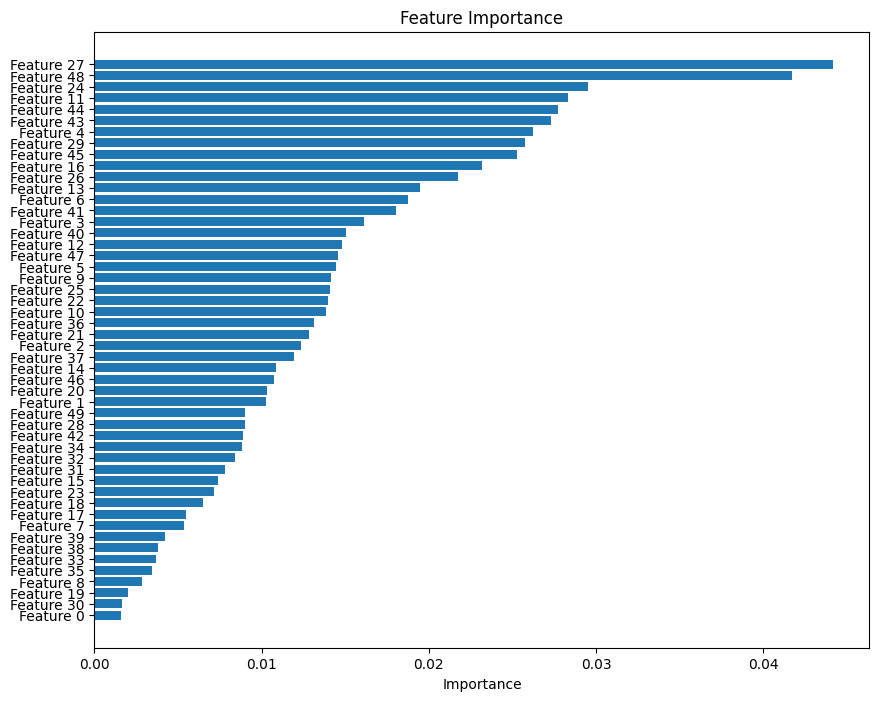

In [31]:
# Feature importance for logistic regression
if hasattr(classifier, 'coef_'):
    importance = np.abs(classifier.coef_[0])
    feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

    print('Feature Importance:')
    for feature, importance in feature_importance:
        print(f'{feature}: {importance}')

    # Plot feature importance
    feature_names, importances = zip(*feature_importance)
    plt.figure(figsize=(10, 8))
    plt.barh(feature_names, importances, align='center')
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert y axis to have the most important feature at the top
    plt.show()
else:
    print('The classifier does not have a `coef_` attribute.')

# XGboost


Accuracy_xgb: 0.6176470588235294


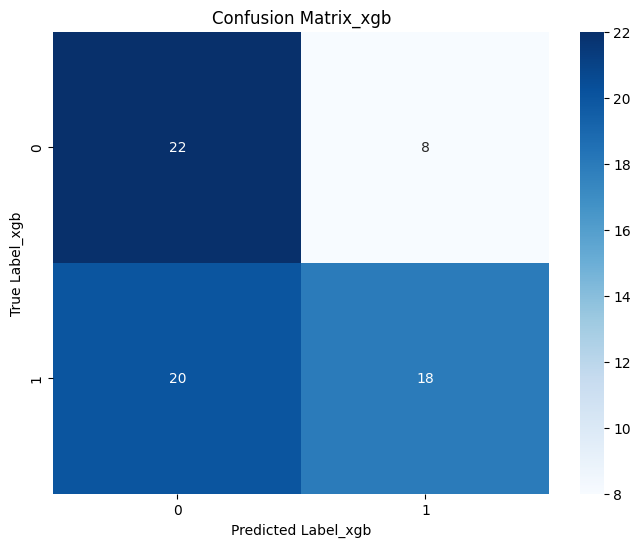

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.73      0.61        30
           1       0.69      0.47      0.56        38

    accuracy                           0.59        68
   macro avg       0.61      0.60      0.59        68
weighted avg       0.62      0.59      0.58        68



In [32]:
from xgboost import XGBClassifier

# Initialize the classifier
classifier_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the classifier
classifier_xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = classifier_xgb.predict(X_test)
y_pred_prob_pca_xg = classifier_xgb.predict_proba(X_test)[:, 1]

# Evaluate the classifier
accuracy_xgb = accuracy_score(y_test, y_pred)
print(f'Accuracy_xgb: {accuracy_xgb}')

# Compute the confusion matrix
matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=classifier_xgb.classes_, yticklabels=classifier_xgb.classes_)
plt.xlabel('Predicted Label_xgb')
plt.ylabel('True Label_xgb')
plt.title('Confusion Matrix_xgb')
plt.show()

report = classification_report(y_test, y_pred_xgb)
print('Classification Report:')
print(report)

In [33]:
# Perform cross-validation for XGBOOST
cv_scores_xgb = cross_val_score(classifier_xgb, X, y, cv=5)

print(f'Cross-validation scores: {cv_scores_xgb}')
print(f'Mean CV score: {cv_scores_xgb.mean()}')


Cross-validation scores: [0.61764706 0.51470588 0.58823529 0.63235294 0.6119403 ]
Mean CV score: 0.5929762949956101


# Grid Search XGboost

In [34]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.1, 1],
#     'reg_lambda': [1, 1.5, 2]
# }

# # Initialize the classifier
# classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# print(f'Best Parameters: {grid_search.best_params_}')
# print(f'Best Score: {grid_search.best_score_}')

# # Use the best estimator to make predictions
# best_classifier = grid_search.best_estimator_
# y_pred = best_classifier.predict(X_test)

# # Evaluate the classifier
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')


# Random forest

Accuracy_task: 0.5735294117647058


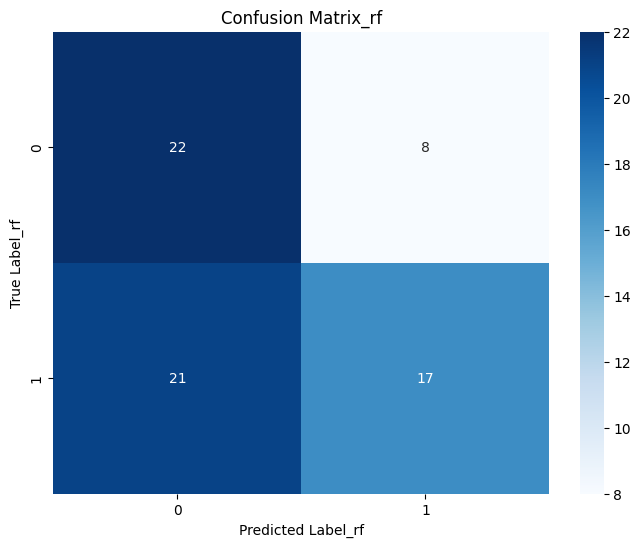

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.73      0.60        30
           1       0.68      0.45      0.54        38

    accuracy                           0.57        68
   macro avg       0.60      0.59      0.57        68
weighted avg       0.61      0.57      0.57        68



In [35]:
from sklearn.ensemble import RandomForestClassifier

# Assuming you have X_train, y_train, X_test, and y_test defined

# Create a Random Forest classifier
rf_classifier_task = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier_task.fit(X_train, y_train)


# Make predictions on the test data
y_pred_task_rf = rf_classifier_task.predict(X_test)
y_pred_prob_pca_rf = rf_classifier_task.predict_proba(X_test)[:, 1]


# Evaluate the model's performance
accuracy_task = accuracy_score(y_test, y_pred_task_rf)
print("Accuracy_task:", accuracy_task)

# Compute the confusion matrix
matrix_task_rf = confusion_matrix(y_test, y_pred_task_rf)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_task_rf, annot=True, fmt='d', cmap='Blues', xticklabels=classifier_xgb.classes_, yticklabels=classifier_xgb.classes_)
plt.xlabel('Predicted Label_rf')
plt.ylabel('True Label_rf')
plt.title('Confusion Matrix_rf')
plt.show()

report = classification_report(y_test, y_pred_task_rf)
print('Classification Report:')
print(report)

# SVM

Accuracy_svm_task: 0.4411764705882353
Classification Report_svm_task:
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        30
           1       0.00      0.00      0.00        38

    accuracy                           0.44        68
   macro avg       0.22      0.50      0.31        68
weighted avg       0.19      0.44      0.27        68



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


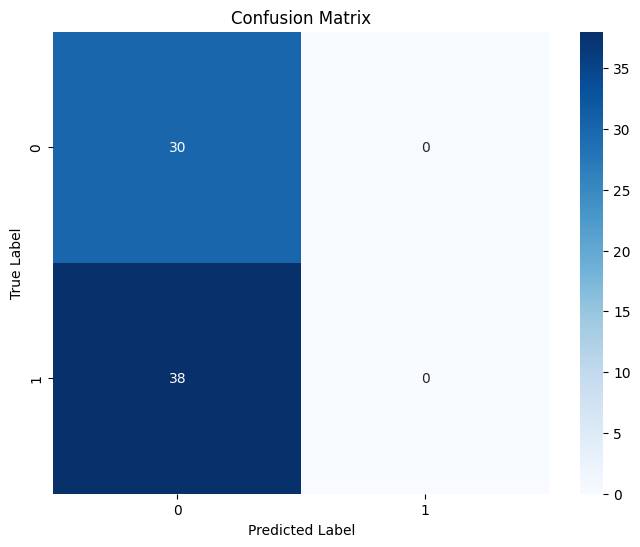

In [36]:
import numpy as np
# from sklearn.modelselection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# # Suponiendo que principal_components es tu conjunto de características y y es tu variable objetivo
# X = principal_components_task
# y = labels_vector  # Reemplaza con tu variable objetivo real

# # Dividir los datos en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

# Inicializar el clasificador SVM
classifier_svm_task = SVC(C = 0.1, gamma= 0.1, kernel='rbf', random_state=42, probability=True)

#classifier_svm_task = SVC(kernel='linear', random_state=42)

# Entrenar el clasificador
classifier_svm_task.fit(X_train, y_train)

# Hacer predicciones
y_pred_svm_task = classifier_svm_task.predict(X_test)
y_pred_prob_pca_svm = classifier_svm_task.predict_proba(X_test)[:, 1]


# Evaluar el clasificador
accuracy_svm_task = accuracy_score(y_test, y_pred_svm_task)
print(f'Accuracy_svm_task: {accuracy_svm_task}')

report_svm_task = classification_report(y_test, y_pred_svm_task)
print('Classification Report_svm_task:')
print(report_svm_task)

# Matriz de confusión
matrix_svm_task = confusion_matrix(y_test, y_pred_svm_task)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_svm_task, annot=True, fmt='d', cmap='Blues', xticklabels=classifier_svm_task.classes_, yticklabels=classifier_svm_task.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# AUC-ROC plots

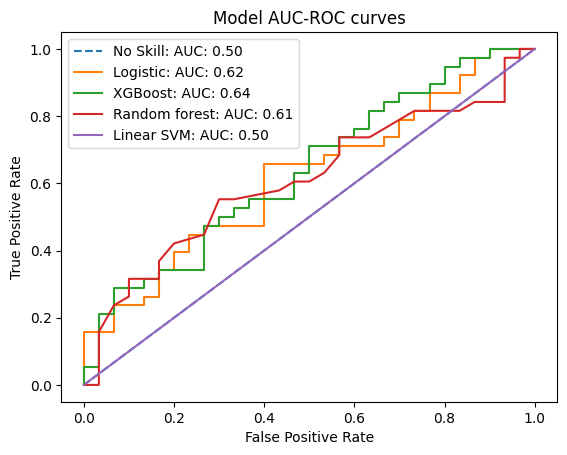

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ns_auc = roc_auc_score(y_test, ns_probs)

# PCA LogReg classifier AUC and ROC values
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_pred_prob_pca_lr)
lr_auc = roc_auc_score(y_test, y_pred_prob_pca_lr)


#PCA XGboost Classifier values
xg_fpr, xg_tpr, xg_thresholds = roc_curve(y_test, y_pred_prob_pca_xg)
xg_auc = roc_auc_score(y_test, y_pred_prob_pca_xg)

# PCA random forst classifier values
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_pred_prob_pca_rf)
rf_auc = roc_auc_score(y_test, y_pred_prob_pca_rf)

# PCA SVM values
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, y_pred_prob_pca_svm)
svm_auc = roc_auc_score(y_test, y_pred_prob_pca_svm)

#Plot all together
plt.plot(ns_fpr, ns_tpr, linestyle='--', label=f'No Skill: AUC: {ns_auc:.2f}')
plt.plot(lr_fpr, lr_tpr, marker='', label=f'Logistic: AUC: {lr_auc:.2f}')
plt.plot(xg_fpr, xg_tpr, marker='', label=f'XGBoost: AUC: {xg_auc:.2f}')
plt.plot(rf_fpr, rf_tpr, marker='', label=f'Random forest: AUC: {rf_auc:.2f}')
plt.plot(svm_fpr, svm_tpr, marker='', label=f'Linear SVM: AUC: {svm_auc:.2f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model AUC-ROC curves")
# show the legend
plt.legend()
# show the plot
plt.show()